In [46]:
import logging
from binance.um_futures import UMFutures as Client
from binance.lib.utils import config_logging
from binance.error import ClientError
import dateparser
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import os
from scipy import signal
from datetime import datetime

In [47]:
akey = os.environ.get("API_KEY")
asec = os.environ.get("API_SECRET")


#config_logging(logging, logging.DEBUG)
futures_client = Client(key = akey, secret= asec)

In [48]:
#PARAMETERS
TIMEFRAME = "1h"
PAIR = "BTCUSDT"
DATA_WINDOW_LENGTH = 500
ROLLING_WINDOW_LENGTH = 12 #this is correlated with the chosen TIMEFRAME and as such should be a function of that; something about the frequency of local minima and maxima
CALLBACKRATE_FACTOR = 10
FROM_DATE = "2021-10-14 01:00:00" 
TO_DATE = "2021-02-02"
NUM_DATA = 5000


In [49]:
def process_klines(klines):

    df = pd.DataFrame(klines)
    df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'trades', 'taker_buy_volume', 'taker_buy_quote_asset_volume', 'ignore']
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
    df['open'] = pd.to_numeric(df['open'])
    df['high'] = pd.to_numeric(df['high'])
    df['low'] = pd.to_numeric(df['low'])
    df['close'] = pd.to_numeric(df['close'])
    df['volume'] = pd.to_numeric(df['volume'])
    df['quote_asset_volume'] = pd.to_numeric(df['quote_asset_volume'])
    df['trades'] = pd.to_numeric(df['trades'])
    df['taker_buy_volume'] = pd.to_numeric(df['taker_buy_volume'])
    df['taker_buy_quote_asset_volume'] = pd.to_numeric(df['taker_buy_quote_asset_volume'])
    df['ignore'] = pd.to_numeric(df['ignore'])
    df.drop(['ignore'], axis=1, inplace=True)
    return df

In [50]:
from_date = dateparser.parse(FROM_DATE)
print(from_date)
from_date = round(datetime.timestamp(from_date))*1000
print(from_date)
# from_date = datetime.fromtimestamp(from_date)
# print(from_date)

2021-10-14 01:00:00
1634184000000


/home/istrozzi/.local/lib/python3.10/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


In [51]:
klines = futures_client.continuous_klines(PAIR, 'PERPETUAL', TIMEFRAME, startTime = from_date)
klines = process_klines(klines)
df = klines.copy()

In [52]:
new_from_date = round(datetime.timestamp(df.iloc[-1].open_time))*1000
print(df.iloc[-1].open_time, new_from_date)

2021-11-03 23:00:00 1635991200000


In [53]:
klines = futures_client.continuous_klines(PAIR, 'PERPETUAL', TIMEFRAME, startTime = new_from_date)
klines = process_klines(klines)

In [54]:
df = pd.concat([df, klines.copy()], axis=0).reset_index(drop=True)

In [55]:
df.shape

(1000, 11)

In [41]:
%%capture
config_logging(logging, logging.DEBUG)
futures_client = Client(key = akey, secret= asec)
# logging.info(futures_client.continuous_klines("BTCUSDT", 'PERPETUAL', '15m', limit=100));
klines_i = futures_client.continuous_klines(PAIR, 'PERPETUAL', TIMEFRAME, limit=500);
klines_i.iloc[-1][]
# klines = futures_client.continuous_klines(PAIR, 'PERPETUAL', TIMEFRAME, startTime = from_date);

SyntaxError: invalid syntax (2132718042.py, line 5)

In [33]:
process_klines(klines)

ValueError: Length mismatch: Expected axis has 11 elements, new values have 12 elements

/home/istrozzi/.local/lib/python3.10/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


datetime.datetime(2021, 1, 1, 0, 0)

In [85]:
class StaticDatabase:
    def __init__(self, client, pair, timeframe, contractType = 'PERPETUAL', limit=1000):
        self.client = client
        self.pair = pair
        self.timeframe = timeframe
        self.contractType = contractType
        self.limit = limit
        self.data = self.process_klines(self.client.continuous_klines(self.pair, self.contractType, self.timeframe, limit = limit))    
    
    def get_historical_klines(self, from_date, to_date):
        while len(self.data) < NUM_DATA:
            self.data = self.process_klines(self.client.continuous_klines(self.pair, self.contractType, self.timeframe, startTime = from_date, endTime=to_date))    
    
    def process_klines(self, klines):
        df = pd.DataFrame(klines)
        df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'trades', 'taker_buy_volume', 'taker_buy_quote_asset_volume', 'ignore']
        df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
        df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
        df['open'] = pd.to_numeric(df['open'])
        df['high'] = pd.to_numeric(df['high'])
        df['low'] = pd.to_numeric(df['low'])
        df['close'] = pd.to_numeric(df['close'])
        df['volume'] = pd.to_numeric(df['volume'])
        df['quote_asset_volume'] = pd.to_numeric(df['quote_asset_volume'])
        df['trades'] = pd.to_numeric(df['trades'])
        df['taker_buy_volume'] = pd.to_numeric(df['taker_buy_volume'])
        df['taker_buy_quote_asset_volume'] = pd.to_numeric(df['taker_buy_quote_asset_volume'])
        df['ignore'] = pd.to_numeric(df['ignore'])
        df.drop(['ignore'], axis=1, inplace=True)
        return df    
            # self.dataframe = pd.DataFrame()
        # self.dataframe['open'] = pd.Series(dtype='float64')
        # self.dataframe['high'] = pd.Series(dtype='float64')
        # self.dataframe['low'] = pd.Series(dtype='float64')
        # self.dataframe['close'] = pd.Series(dtype='float64')
        # self.dataframe['volume'] = pd.Series(dtype='float64')
        # self.dataframe['openTime'] = pd.Series(dtype='float64')
        # self.dataframe['closeTime'] = pd.Series(dtype='float64')
        # self.dataframe['quoteAssetVolume'] = pd.Series(dtype='float64')
        # self.dataframe['numberOfTrades'] = pd.Series(dtype='float64')
        # self.dataframe['takerBuyBaseAssetVolume'] = pd.Series(dtype='float64')
        # self.dataframe['takerBuyQuoteAssetVolume'] = pd.Series(dtype='float64')
        # self.dataframe['ignore'] = pd.Series(dtype='float64')
        # self.dataframe['contractType'] = pd.Series(dtype='str')
        # self.dataframe['pair'] = pd.Series(dtype='str')
        # self.dataframe['interval'] = pd.Series(dtype='str')
        # self.dataframe['firstTradeId'] = pd.Series(dtype='float64')
        # self.dataframe['lastTradeId'] = pd.Series(dtype='float64')
        # self.dataframe['isFinal'] = pd.Series(dtype='bool')
        # self.dataframe['quoteVolume'] = pd.Series(dtype='float64')
        # self.dataframe['buyVolume'] = pd.Series(dtype='float64')
        # self.dataframe['quoteBuyVolume'] = pd.Series(dtype='float64')
        # self.dataframe['index'] = pd.Series(dtype='float64')
        # self.dataframe['time'] = pd.Series(dtype='float64')
        # self.dataframe['timeframe'] = pd.Series(dtype='str')
        # self.dataframe['timeframe_seconds'] = pd.Series(dtype='float64')
        # self.dataframe['timeframe_minutes'] = pd.Series(dtype='float64')
        # self.dataframe['timeframe_hours'] = pd.Series(dtype='float64')
        # self.dataframe['timeframe_days'] = pd.Series(dtype='float64')
        # self.dataframe['timeframe_weeks'] = pd.Series(dtype='float64')
        # self.dataframe['timeframe_months'] = pd
dateparser.parse("2021-01-01")

/home/istrozzi/.local/lib/python3.10/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


datetime.datetime(2021, 1, 1, 0, 0)

In [86]:
sdb = StaticDatabase(futures_client, PAIR, TIMEFRAME)

In [87]:
sdb.get_historical_klines(dateparser.parse(FROM_DATE), dateparser.parse(TO_DATE))

In [88]:
sdb.data

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume
0,2022-09-25 01:00:00,274.76,275.95,274.57,275.37,32090.24,2022-09-25 01:59:59.999,8.835382e+06,15846,16298.03,4.486904e+06
1,2022-09-25 02:00:00,275.36,275.96,274.37,275.57,29912.40,2022-09-25 02:59:59.999,8.237199e+06,13449,13435.29,3.699864e+06
2,2022-09-25 03:00:00,275.57,276.31,274.39,276.23,30511.13,2022-09-25 03:59:59.999,8.408689e+06,15704,12313.77,3.393854e+06
3,2022-09-25 04:00:00,276.23,276.27,275.03,275.41,17102.55,2022-09-25 04:59:59.999,4.712438e+06,11057,6229.89,1.716380e+06
4,2022-09-25 05:00:00,275.42,275.85,274.21,275.69,25180.57,2022-09-25 05:59:59.999,6.927147e+06,13896,12426.13,3.418358e+06
...,...,...,...,...,...,...,...,...,...,...,...
495,2022-10-15 16:00:00,271.00,271.17,269.89,270.16,29432.20,2022-10-15 16:59:59.999,7.963415e+06,13458,12095.71,3.273458e+06
496,2022-10-15 17:00:00,270.17,270.21,269.29,269.46,22124.09,2022-10-15 17:59:59.999,5.968170e+06,13002,11436.36,3.085327e+06
497,2022-10-15 18:00:00,269.45,269.82,269.34,269.67,14609.01,2022-10-15 18:59:59.999,3.938355e+06,8983,7650.36,2.062431e+06
498,2022-10-15 19:00:00,269.68,270.04,269.34,269.86,13063.61,2022-10-15 19:59:59.999,3.524414e+06,9084,6517.87,1.758510e+06


In [6]:
df = process_klines(klines)

In [7]:
closes_mean = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).mean()
closes_std = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).std()
mean_std = closes_std.mean()
closes_mean.mean(), mean_std

(319.17945519318187, 6.785223438453965)

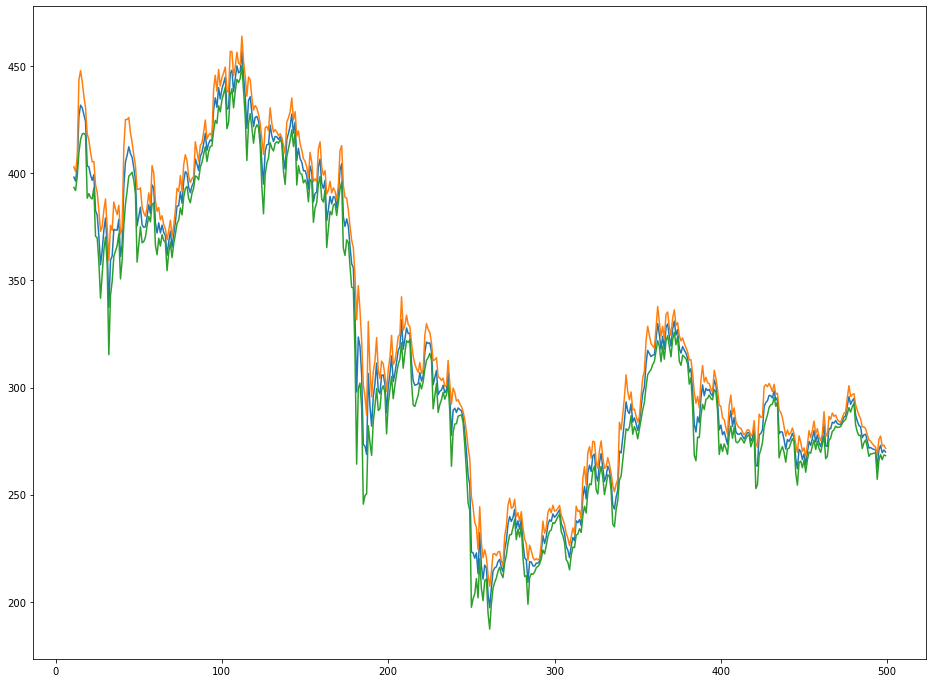

In [8]:
(fig, ax) = plt.subplots(figsize=(16,12))
ax.plot(closes_mean)
ax.plot(closes_mean + closes_std)
ax.plot(closes_mean - closes_std)

In [9]:

# peak_indexes, _ = signal.find_peaks(df.close.values, threshold=mean_std/2)
# peak_indexes, _ = signal.find_peaks(df.close.values, prominence=1.5*mean_std)
peak_indexes, _ = signal.find_peaks(df.close.values, prominence=2*mean_std)
print(peak_indexes)

# valley_indexes, _ = signal.find_peaks(-1*df.close.values, threshold=mean_std/2)
# valley_indexes, _ = signal.find_peaks(-1*df.close.values, prominence=1.5*mean_std)
valley_indexes, _ = signal.find_peaks((-1)*df.close.values, prominence=2*mean_std)
print(valley_indexes)

[  4  15  30  38  44  58 102 112 117 129 142 159 172 182 188 193 208 223
 242 255 276 303 328 343 372 396 406 432 477]
[  1  12  27  32  39  49  67 103 115 125 138 155 163 181 187 190 199 216
 238 254 261 284 309 336 350 385 404 421 446]


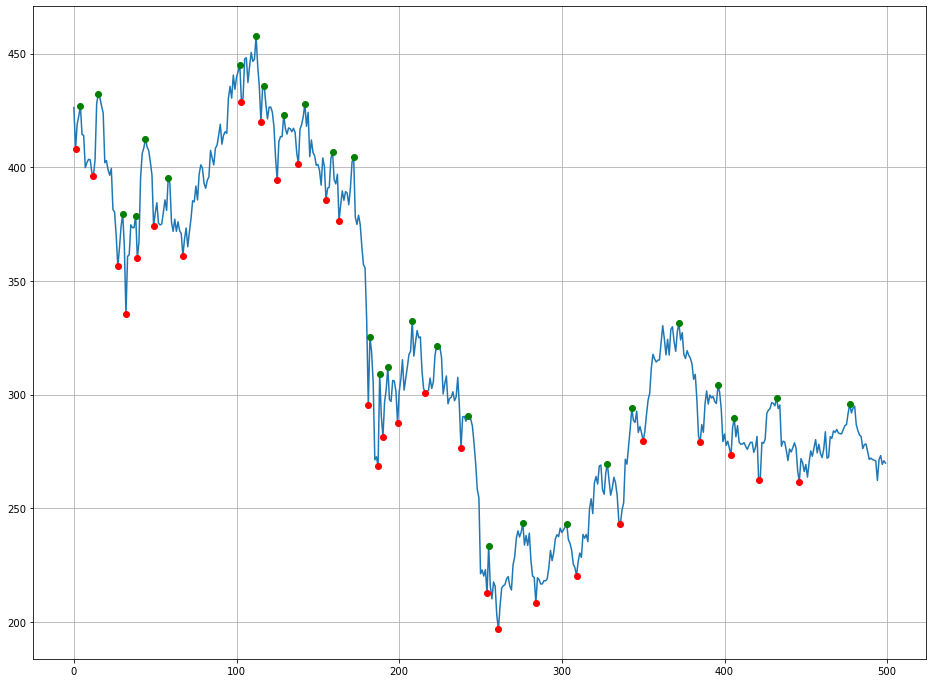

In [10]:
# plot peaks
(fig, ax) = plt.subplots(figsize=(16,12))
ax.plot(df.close)

peak_x = peak_indexes
peak_y = df.close.values[peak_indexes]
ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")
 
# plot valleys
valley_x = valley_indexes
valley_y = df.close.values[valley_indexes]
ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")

ax.grid()

In [11]:
peak_regions = []
for peak_index in peak_indexes:
    peak_regions.append(peak_index)
    for j in range(min(max(peak_index+1, len(df.close.values) - max(peak_indexes)), 5)):
        if np.abs(df.close.values[peak_index-j] - df.close.values[peak_index]) < mean_std/4:
            peak_regions.append(peak_index-j)
        elif np.abs(df.close.values[peak_index+j] - df.close.values[peak_index]) < mean_std/4:
            peak_regions.append(peak_index+j)        
print(len(peak_regions) - len(peak_indexes))
valley_regions = []
for valley_index in valley_indexes:
    for j in range(min(valley_index+1, len(df.close.values) - max(valley_indexes))):
        if np.abs(df.close.values[valley_index-j] - df.close.values[valley_index]) < mean_std/4:
            valley_regions.append(valley_index-j)
        elif np.abs(df.close.values[valley_index+j] - df.close.values[valley_index]) < mean_std/4:
            valley_regions.append(valley_index+j)    
print(len(valley_regions) - len(valley_indexes))

43
88


In [12]:
len(peak_regions) - len(peak_indexes)

43

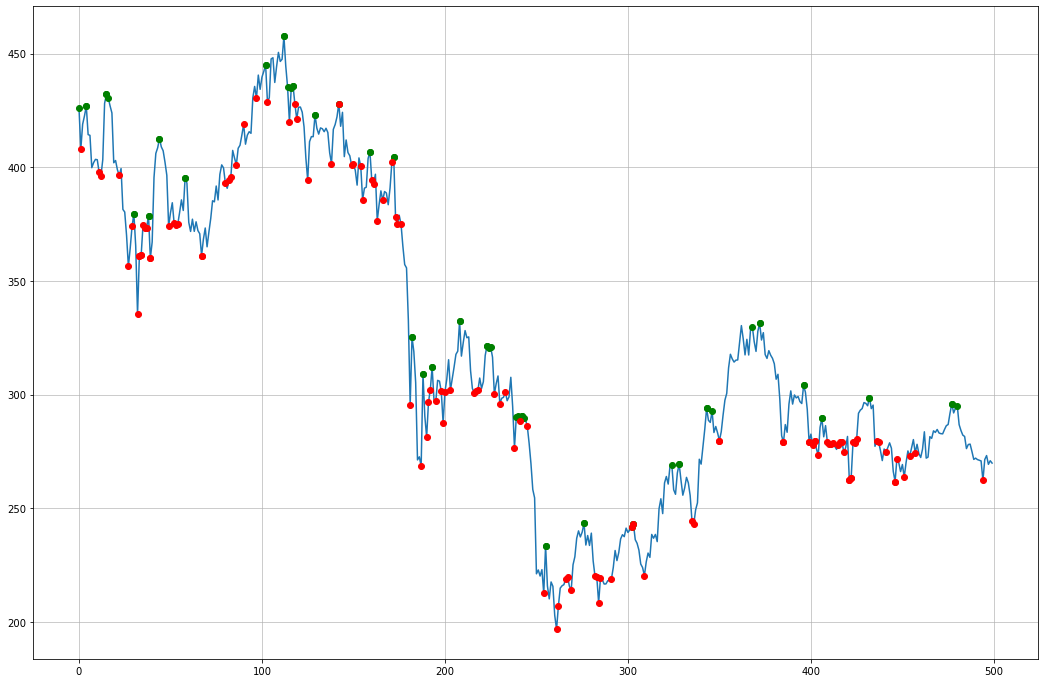

In [13]:
(fig, ax) = plt.subplots(figsize=(18,12))
ax.plot(df.close)

peak_x = peak_regions
peak_y = df.close.values[peak_regions]
ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")

valley_x = valley_regions
valley_y = df.close.values[valley_regions]
ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")
ax.grid(which='both', alpha=0.8)
ax.grid(True, which="minor")


In [14]:
labels = [1 if i in peak_regions else (-1 if i in valley_regions else 0) for i in range(len(df.close.values))]
labels = pd.DataFrame(labels, columns=['labels'])
df = pd.concat([df, labels], axis=1)
print(labels[labels!=0].dropna())
    

     labels
0       1.0
1      -1.0
4       1.0
11     -1.0
12     -1.0
..      ...
454    -1.0
457    -1.0
477     1.0
480     1.0
494    -1.0

[146 rows x 1 columns]


In [15]:
df


,open_time,open,high,low,close,volume,close_time,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume,labels
0,2022-02-08 00:00:00,433.14,445.48,420.80,426.27,684172.01,2022-02-08 11:59:59.999,2.959951e+08,383006,322404.81,1.395451e+08,1
1,2022-02-08 12:00:00,426.27,426.29,406.26,407.94,771346.28,2022-02-08 23:59:59.999,3.196802e+08,452780,375909.11,1.557726e+08,-1
2,2022-02-09 00:00:00,407.96,419.73,407.22,418.92,567391.44,2022-02-09 11:59:59.999,2.343230e+08,334605,276495.93,1.141807e+08,0
3,2022-02-09 12:00:00,418.92,427.49,417.55,422.57,596781.94,2022-02-09 23:59:59.999,2.523297e+08,345580,280516.74,1.186349e+08,0
4,2022-02-10 00:00:00,422.56,429.96,414.44,426.89,480447.90,2022-02-10 11:59:59.999,2.027377e+08,299576,232275.43,9.804464e+07,1
...,...,...,...,...,...,...,...,...,...,...,...,...
495,2022-10-13 12:00:00,262.23,273.66,255.00,271.40,1119772.74,2022-10-13 23:59:59.999,2.971129e+08,474195,545251.73,1.447347e+08,0
496,2022-10-14 00:00:00,271.39,276.65,271.20,273.16,573314.62,2022-10-14 11:59:59.999,1.572794e+08,253899,280819.52,7.703532e+07,0
497,2022-10-14 12:00:00,273.15,275.35,267.39,269.30,562287.07,2022-10-14 23:59:59.999,1.525116e+08,258969,271909.99,7.376979e+07,0
498,2022-10-15 00:00:00,269.30,271.10,268.60,270.89,238257.63,2022-10-15 11:59:59.999,6.430961e+07,135366,115253.82,3.111167e+07,0


In [16]:
features = df[['open_time', 'open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'trades', 'taker_buy_volume', 'taker_buy_quote_asset_volume', 'labels']]
dates = features['open_time'].copy()
# timestamps = pd.to_datetime(features['open_time'], unit='ms')
# print(features['open_time'], type(timestamps), type(features['open_time']))
# features['open_time'] = timestamps
features.rename(columns={"open_time": "timestamp"}, inplace=True)

/tmp/ipykernel_54167/2604319273.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.rename(columns={"open_time": "timestamp"}, inplace=True)


In [17]:
features

,timestamp,open,high,low,close,volume,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume,labels
0,2022-02-08 00:00:00,433.14,445.48,420.80,426.27,684172.01,2.959951e+08,383006,322404.81,1.395451e+08,1
1,2022-02-08 12:00:00,426.27,426.29,406.26,407.94,771346.28,3.196802e+08,452780,375909.11,1.557726e+08,-1
2,2022-02-09 00:00:00,407.96,419.73,407.22,418.92,567391.44,2.343230e+08,334605,276495.93,1.141807e+08,0
3,2022-02-09 12:00:00,418.92,427.49,417.55,422.57,596781.94,2.523297e+08,345580,280516.74,1.186349e+08,0
4,2022-02-10 00:00:00,422.56,429.96,414.44,426.89,480447.90,2.027377e+08,299576,232275.43,9.804464e+07,1
...,...,...,...,...,...,...,...,...,...,...,...
495,2022-10-13 12:00:00,262.23,273.66,255.00,271.40,1119772.74,2.971129e+08,474195,545251.73,1.447347e+08,0
496,2022-10-14 00:00:00,271.39,276.65,271.20,273.16,573314.62,1.572794e+08,253899,280819.52,7.703532e+07,0
497,2022-10-14 12:00:00,273.15,275.35,267.39,269.30,562287.07,1.525116e+08,258969,271909.99,7.376979e+07,0
498,2022-10-15 00:00:00,269.30,271.10,268.60,270.89,238257.63,6.430961e+07,135366,115253.82,3.111167e+07,0


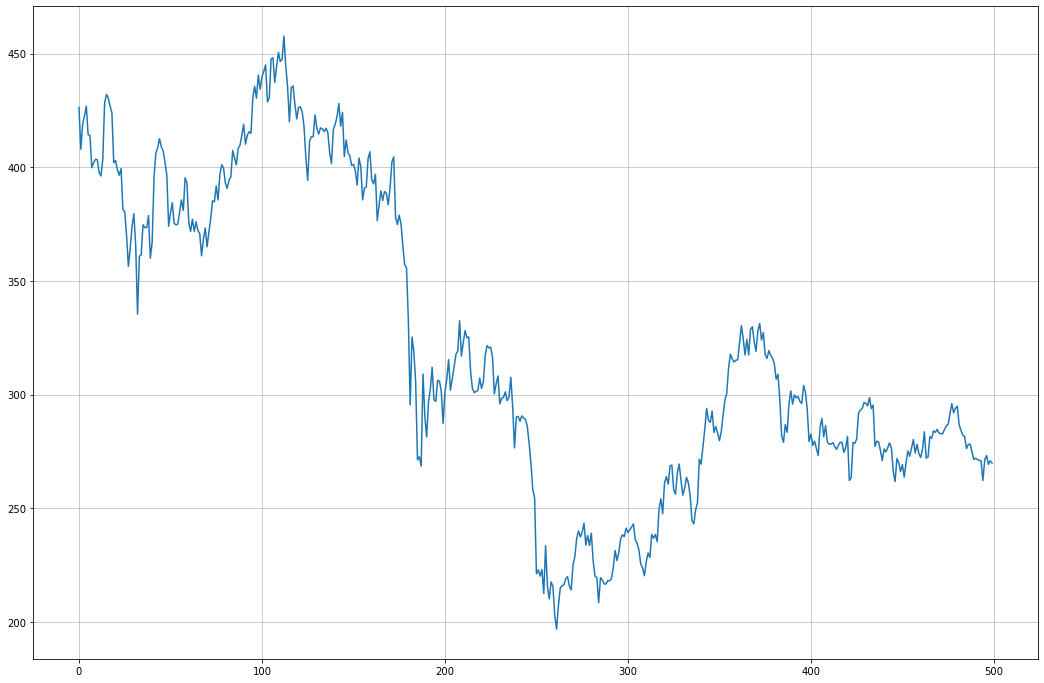

In [18]:
(fig, ax) = plt.subplots(figsize=(18,12))
ax.plot(df.close)
none = []
for i, l in enumerate(labels):
    if l == 1:
        peak_x = peak_regions
        peak_y = df.close.values[peak_regions]
        ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")
    elif l == -1:
        valley_x = valley_regions
        valley_y = df.close.values[valley_regions]
        ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")
    elif l == 0:
        none.append(i)
none_x = none
none_y = df.close.values[none]
ax.plot(none_x, none_y, marker='o', linestyle="None", color='yellow', alpha=0.5, label="Valleys")        
# ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")
# ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")
ax.grid(which='both', alpha=0.8)
ax.grid(True, which="minor")

In [19]:
from torchvision.io import read_image
from torch.utils.data import Dataset

class MarketDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [20]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

NameError: name 'training_data' is not defined

In [ ]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
class LSTM(nn.Module):
    def __init__(self, hidden_layers=64):
        super(LSTM, self).__init__()
        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.LSTMCell(1, self.hidden_layers)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, 1)
        
    def forward(self, y, future_preds=0):
        outputs, num_samples = [], y.size(0)
        h_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        
        for time_step in y.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm1(input_t, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)
            
        for i in range(future_preds):
            # this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs